In [1]:
from sqlalchemy import create_engine, inspect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, time, datetime
import pymysql

#Datos de conexión
usuario='EquipoB'
contraseña="E1q2u3i4p5oB"
host='212.227.90.6'
puerto=3306
nombre_base_datos='EquipB'

#URL de la conexión
url_conexion=f"mysql+pymysql://{usuario}:{contraseña}@{host}:{puerto}/{nombre_base_datos}"

#Crear l'engine de SQLAlchemy
try:
    engine=create_engine(url_conexion)
    cnx=engine.connect()
    print("Conexión correcta")
except Exception as e:
    print(f"Error al conectar con SQLAlchemy: {e}")
    
#Obtener el nombre de les tablas
inspector=inspect(engine)
nombre_tablas=inspector.get_table_names()

# Diccionario para almacenar los DataFrames
df= {}

for tabla in nombre_tablas:
    query=f"SELECT * FROM {tabla}"
    
    try:
        df[tabla] = pd.read_sql(query, cnx)
        print(f"Tabla '{tabla}' cargada correctamente.")
    except Exception as e:
        print(f"Error al cargar la tabla '{tabla}':{e}")
  
# Cerrrar la conexión
cnx.close()

Conexión correcta
Tabla 'BANK_marketing' cargada correctamente.
Tabla 'BANK_marketing131024' cargada correctamente.


In [2]:
df_bank = df['BANK_marketing131024']

df_bank

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,1,59,admin.,married,secondary,0,2343,1,0,unknown,5,may,1042,1,-1,0,unknown,1
1,2,59,admin.,married,secondary,0,2343,1,0,unknown,5,may,1042,1,-1,0,unknown,1
2,3,56,admin.,married,secondary,0,45,0,0,unknown,5,may,1467,1,-1,0,unknown,1
3,4,41,technician,married,secondary,0,1270,1,0,unknown,5,may,1389,1,-1,0,unknown,1
4,5,55,services,married,secondary,0,2476,1,0,unknown,5,may,579,1,-1,0,unknown,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16158,21379,26,admin.,married,secondary,0,1595,0,0,cellular,15,jun,155,1,105,1,failure,1
16159,21380,37,admin.,married,secondary,0,1967,0,0,cellular,27,may,242,1,212,1,success,1
16160,21381,45,management,married,tertiary,0,81,0,1,cellular,30,jul,61,3,-1,0,unknown,0
16161,21382,44,services,single,secondary,0,618,0,0,cellular,12,may,193,1,-1,0,unknown,1


In [3]:
#vista de las columnas relevantes para el análisis financiero
df_finanzas = df_bank[['id','age','job','marital','education','default','balance','housing','loan']]

In [4]:
df_finanzas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16163 entries, 0 to 16162
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         16163 non-null  int64 
 1   age        16163 non-null  int64 
 2   job        16163 non-null  object
 3   marital    16163 non-null  object
 4   education  16163 non-null  object
 5   default    16163 non-null  int64 
 6   balance    16163 non-null  int64 
 7   housing    16163 non-null  int64 
 8   loan       16163 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 1.1+ MB


In [5]:
df_finanzas.isnull().sum()

id           0
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
dtype: int64

### Varible "housing"

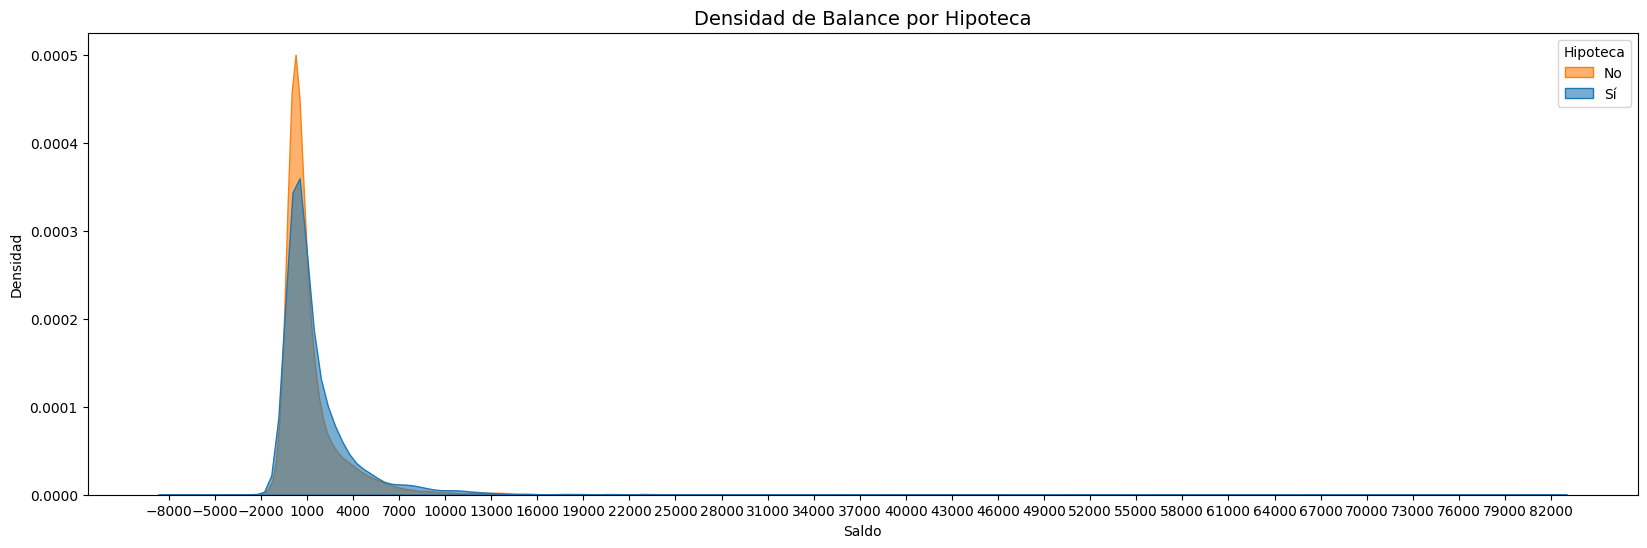

In [6]:
plt.figure(figsize=(20, 6))

sns.kdeplot(data=df_finanzas, x='balance', hue='housing', fill=True, common_norm=False, alpha=0.6)

plt.title('Densidad de Balance por Hipoteca', fontsize=14)
plt.legend(title="Hipoteca", labels=["No","Sí"])
plt.xlabel('Saldo')
plt.ylabel('Densidad')

plt.xticks(range(-8000,85000,3000))

plt.show()

### Categorización 

Definimos 4 categorías para clasificar los clientes (nombres provisionales): 
* **Hsi_Lsi**: Sí hipoteca (Housing), Sí préstamo (Loan)
* **Hsi_Lno**: Sí hipoteca, No préstamo
* **Hno_Lsi**: No hipoteca, Sí préstamo
* **Hno_Lno**: No hipoteca, No préstamo

In [7]:
def clasificacion_clientes (housing, loan):
    if housing == 1 and loan == 1:
        return "Hsi_Lsi"
    elif housing == 1 and loan == 0:
        return "Hsi_Lno"
    elif housing == 0 and loan == 1:
        return "Hno_Lsi"
    elif housing == 0 and loan == 0:
        return "Hno_Lno"
    else:
        return "No categorizado" # no deberíamos tener clientes en esta categoria
    
    
# para clasificar a los clientes segun los dos parametros utilizados en la funcion: 
# df['col_3'] = df.apply(lambda x: f(x.col_1, x.col_2), axis=1)

df_finanzas["categoria_cliente"] = df_finanzas.apply(lambda x: clasificacion_clientes(x.housing, x.loan), axis=1)


C:\Users\Natalya\AppData\Local\Temp\ipykernel_880\3304996542.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_finanzas["categoria_cliente"] = df_finanzas.apply(lambda x: clasificacion_clientes(x.housing, x.loan), axis=1)


In [8]:
df_finanzas

,id,age,job,marital,education,default,balance,housing,loan,categoria_cliente
0,1,59,admin.,married,secondary,0,2343,1,0,Hsi_Lno
1,2,59,admin.,married,secondary,0,2343,1,0,Hsi_Lno
2,3,56,admin.,married,secondary,0,45,0,0,Hno_Lno
3,4,41,technician,married,secondary,0,1270,1,0,Hsi_Lno
4,5,55,services,married,secondary,0,2476,1,0,Hsi_Lno
...,...,...,...,...,...,...,...,...,...,...
16158,21379,26,admin.,married,secondary,0,1595,0,0,Hno_Lno
16159,21380,37,admin.,married,secondary,0,1967,0,0,Hno_Lno
16160,21381,45,management,married,tertiary,0,81,0,1,Hno_Lsi
16161,21382,44,services,single,secondary,0,618,0,0,Hno_Lno


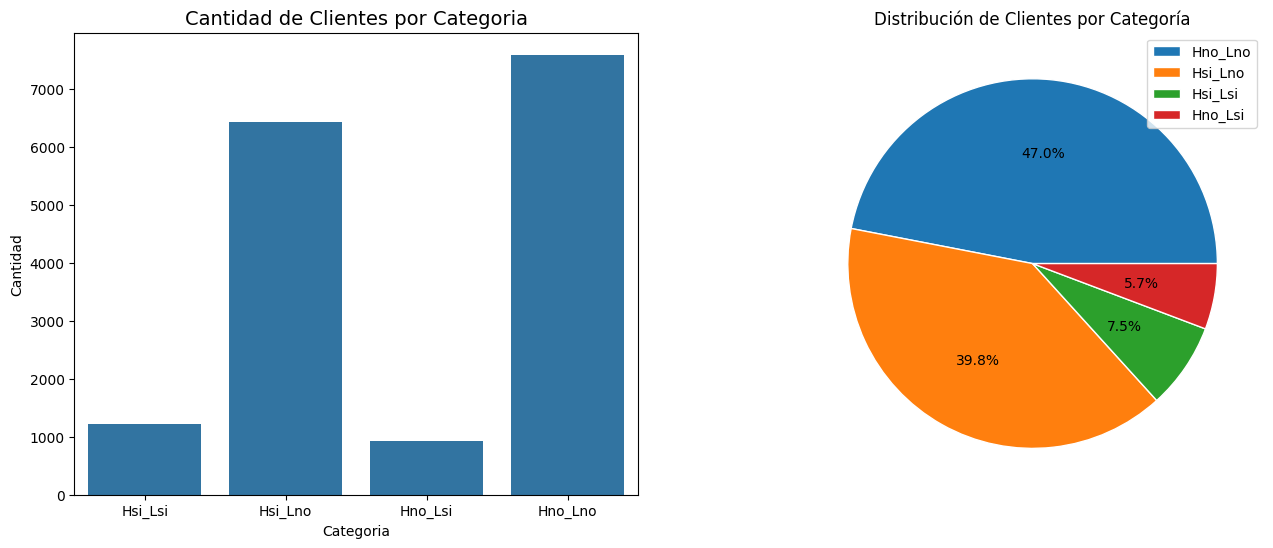

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

sns.countplot(data=df_finanzas,
              x="categoria_cliente",
              order=['Hsi_Lsi','Hsi_Lno','Hno_Lsi','Hno_Lno'],
              ax=ax1)

ax1.set_title('Cantidad de Clientes por Categoria', fontsize=14)
ax1.set_xlabel('Categoria')
ax1.set_ylabel('Cantidad')

categoria_count = df_finanzas['categoria_cliente'].value_counts() 

ax2.pie(categoria_count,  
        autopct='%1.1f%%', 
        wedgeprops={'edgecolor': 'white'})

ax2.set_title('Distribución de Clientes por Categoría')
ax2.legend(categoria_count.index)

plt.show()

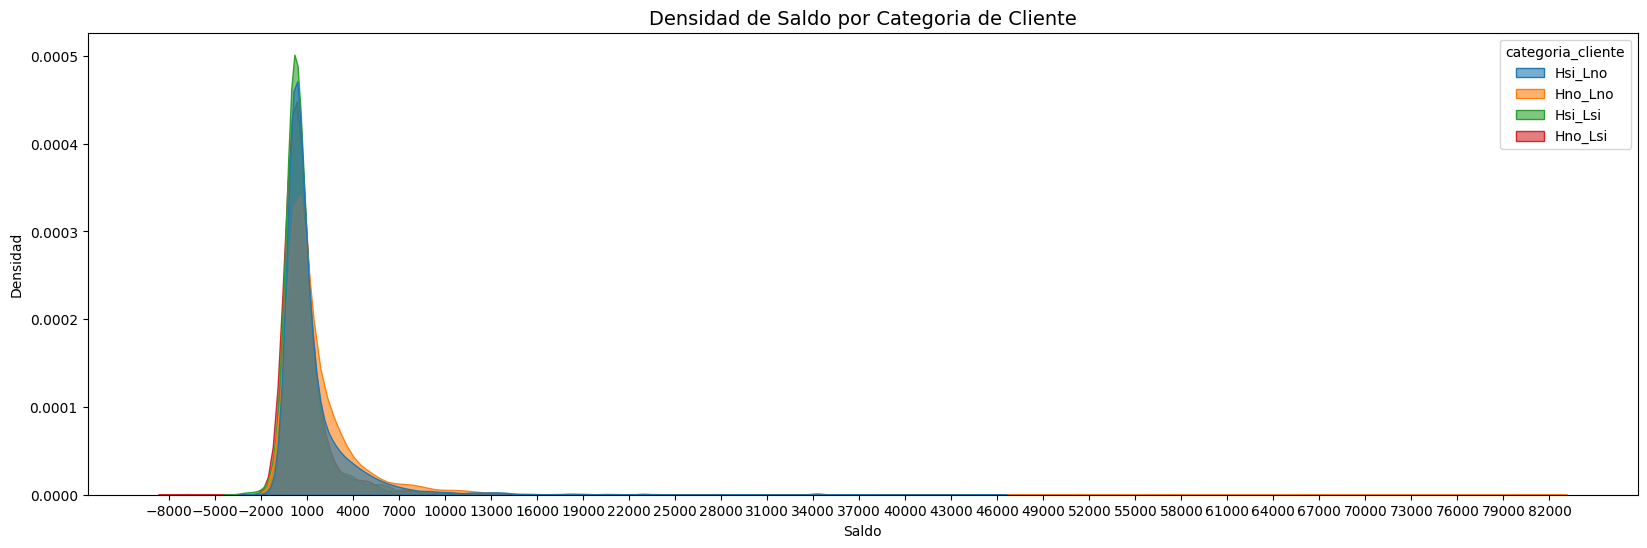

In [10]:
plt.figure(figsize=(20, 6))

sns.kdeplot(data=df_finanzas, x='balance', hue='categoria_cliente', fill=True, common_norm=False, alpha=0.6)

plt.title('Densidad de Saldo por Categoria de Cliente', fontsize=14)
plt.xlabel('Saldo')
plt.ylabel('Densidad')

plt.xticks(range(-8000,85000,3000))

plt.show()

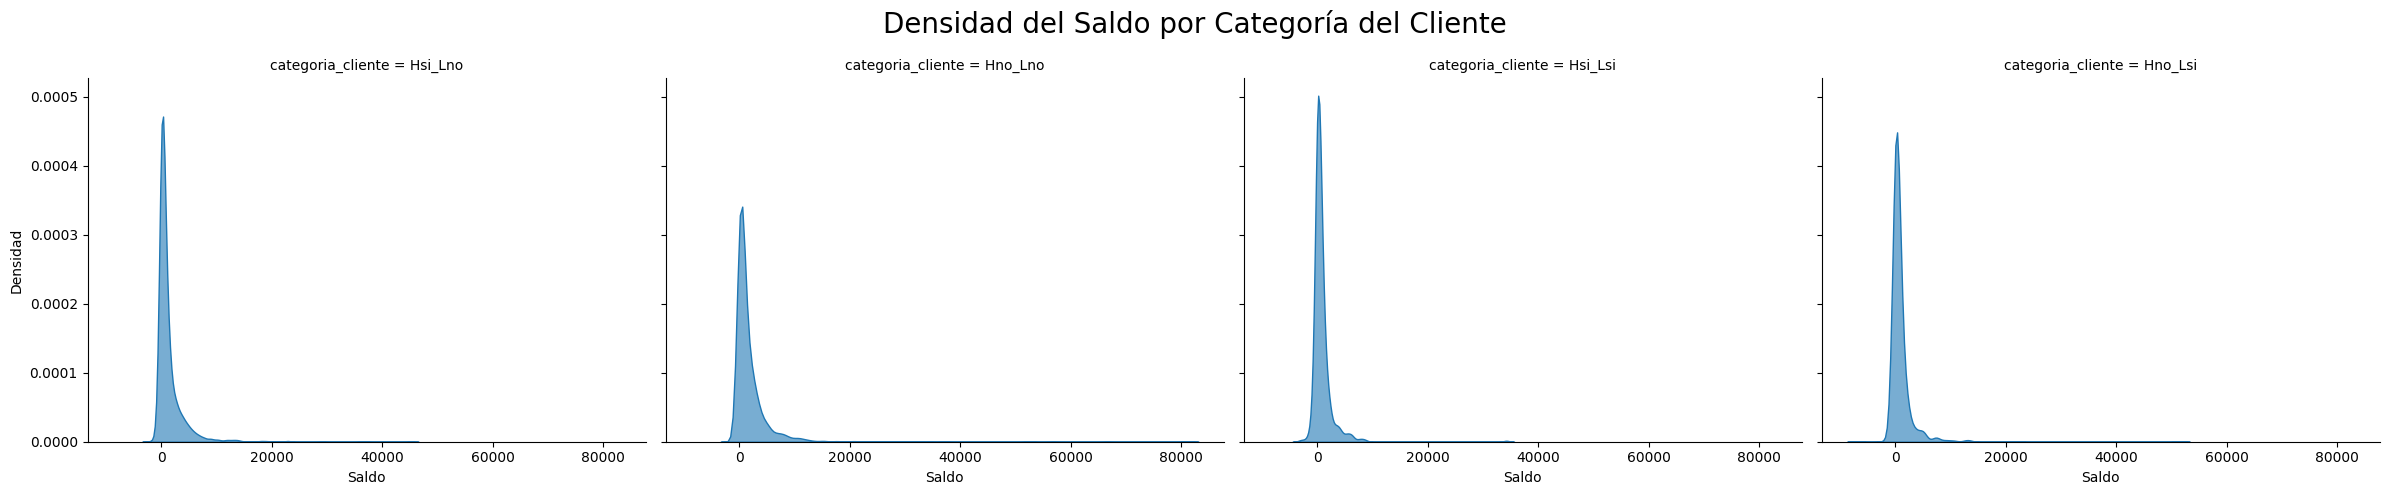

In [11]:
g = sns.FacetGrid(df_finanzas, col='categoria_cliente', col_wrap=4, height=5, aspect=1.2)

g.map(sns.kdeplot, 'balance', fill=True, common_norm=False, alpha=0.6)

g.figure.suptitle('Densidad del Saldo por Categoría del Cliente', fontsize=20)
g.set_axis_labels(x_var='Saldo', y_var='Densidad')
plt.tight_layout()
             
plt.show()

#### Saldo Promedio por Categoría

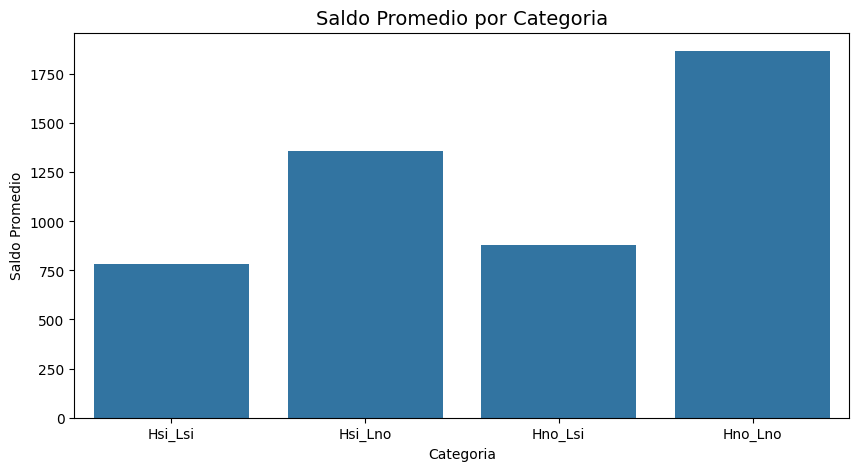

In [12]:
saldo_categoria = df_finanzas.groupby("categoria_cliente")['balance'].mean().reset_index(name="saldo_promedio")

plt.figure(figsize=(10,5))

sns.barplot(data=saldo_categoria,
              x="categoria_cliente",
              y="saldo_promedio",
              order=['Hsi_Lsi','Hsi_Lno','Hno_Lsi','Hno_Lno'])

plt.title('Saldo Promedio por Categoria', fontsize=14)
plt.xlabel('Categoria')
plt.ylabel('Saldo Promedio')

plt.show()

Tabla resumen del saldo promedio, mínimo y máximo para cada categoria de cliente

In [13]:
df_finanzas.groupby("categoria_cliente")[['balance']].agg(['count','mean','min','max']).reset_index()

categoria_cliente balance                          
                      count         mean   min    max
0           Hno_Lno    7590  1868.089987 -1415  81204
1           Hno_Lsi     929   877.978471 -6847  51439
2           Hsi_Lno    6427  1359.357554 -2049  45248
3           Hsi_Lsi    1217   783.285127 -3058  34230

#### Incumplimiento por Categoría

In [14]:
incumplimiento_categoria = pd.merge(df_finanzas.query("default == 1").groupby(by="categoria_cliente").size().reset_index(name="default_si"),
                                    df_finanzas.query("default == 0").groupby(by="categoria_cliente").size().reset_index(name="default_no"),
                                    on="categoria_cliente")

incumplimiento_categoria['total'] = incumplimiento_categoria['default_no'] + incumplimiento_categoria['default_si']
incumplimiento_categoria["% incumplimiento"] = (incumplimiento_categoria['default_si'] / incumplimiento_categoria['total']) * 100

incumplimiento_categoria

,categoria_cliente,default_si,default_no,total,% incumplimiento
0,Hno_Lno,70,7520,7590,0.922266
1,Hno_Lsi,49,880,929,5.274489
2,Hsi_Lno,88,6339,6427,1.369224
3,Hsi_Lsi,34,1183,1217,2.793755


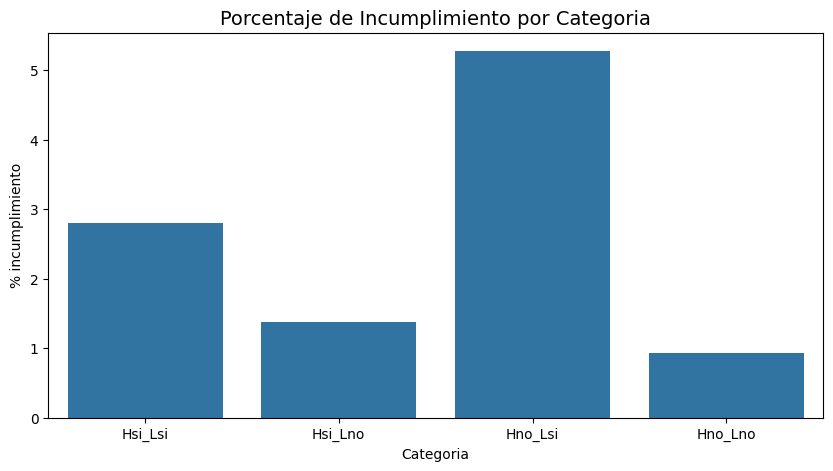

In [15]:
plt.figure(figsize=(10,5))

sns.barplot(data=incumplimiento_categoria,
              x="categoria_cliente",
              y="% incumplimiento",
              order=['Hsi_Lsi','Hsi_Lno','Hno_Lsi','Hno_Lno'])

plt.title('Porcentaje de Incumplimiento por Categoria', fontsize=14)
plt.xlabel('Categoria')
plt.ylabel('% incumplimiento')

plt.show()